In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.layers import Dense, Conv1D, BatchNormalization, Dropout, Input, Activation, MaxPool1D, Flatten
from keras.regularizers import l2
from keras.constraints import MaxNorm
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
from contextlib import redirect_stdout
from collections import defaultdict
import sys
sys.path.append('../../CommonScripts/')
from utils import checkPath, addBack

Using TensorFlow backend.


#### Tunable variables

In [2]:
model_folder = '../Model5/base-f-84-k-1010/'
if os.path.isdir(model_folder):
    raise Exception('Folder already exists')
else:
    os.makedirs(model_folder)
filters1=8
filters2=4
kernel_size1=10
kernel_size2=10
stride1 = 2
stride2 = 2

#### Non-tunable variables

In [3]:
train_file='../Seqs5/train.csv'
test_file='../Seqs5/test.csv'
seq_len=2000
no_splits=3
no_classes=9
no_epochs=200

### Load Data

#### Train Data

In [4]:
train_data = pd.read_csv(train_file) 
X_train_og = train_data.iloc[:, :-2].values
y_train_og = to_categorical(train_data.iloc[:, -2].values)
cv_train_sets = train_data.iloc[:, -1].values 

#### Test Data

In [5]:
test_data = pd.read_csv(test_file)
X_test = test_data.iloc[:, :-1].values
y_test = to_categorical(test_data.iloc[:, -1].values)

#### Standardise X values

In [6]:
scaler = StandardScaler()
scaler.fit(X_train_og)
X_train_og = scaler.transform(X_train_og)
X_test = scaler.transform(X_test)

#### Reshape arrays

In [7]:
X_train_og = np.reshape(X_train_og, (-1, seq_len, 1))
X_test = np.reshape(X_test, (-1, seq_len, 1))

### Load Data

In [8]:
def load_cv_split(ind, X_train=X_train_og, y_train=y_train_og):
    X_train_cv = X_train[cv_train_sets!=ind][:]
    y_train_cv = y_train[cv_train_sets!=ind][:]
    X_val = X_train[cv_train_sets==ind][:]
    y_val = y_train[cv_train_sets==ind][:]
    return (X_train_cv, y_train_cv), (X_val, y_val)

### Model definition

In [9]:
def model_def():
    inputs = Input(shape=(seq_len,1))
    conv1 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='linear', strides=stride1, kernel_regularizer=l2(), bias_regularizer=l2())(inputs)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation(activation='relu')(bn1)
    max_pool1 = MaxPool1D(pool_size=4)(act1)
    conv2 = Conv1D(filters=filters2, kernel_size=kernel_size2, activation='linear', strides=stride2, kernel_regularizer=l2(), bias_regularizer=l2())(max_pool1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation(activation='relu')(bn2)
    max_pool2 = MaxPool1D(pool_size=2)(act2)
    flatten = Flatten()(max_pool2)
    dropout1 = Dropout(0.5)(flatten)
    dense1 = Dense(64, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())(dropout1)
    dropout2 = Dropout(0.5)(dense1)
    dense2 = Dense(32, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())(dropout2)
    dropout3 = Dropout(0.5)(dense2)
    outputs = Dense(no_classes, activation='softmax', kernel_regularizer=l2(), bias_regularizer=l2())(dropout3)
    model = Model(inputs=inputs, outputs=outputs)
    return model

### Train Function

In [10]:
def cv_train(epochs=500):
    histories = []
    for i in range(no_splits):
        # get the data
        (X_train, y_train), (X_val, y_val) = load_cv_split(i)
        # load model
        model = model_def()
        if i == 0:
            # store model summary in a file
            with open(os.path.join(model_folder + 'structure.txt'), 'w') as f:
                with redirect_stdout(f):
                    print(model.summary())
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        model_checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(model_folder + str(i)+'.hdf5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True)
        history = model.fit(X_train, y_train, epochs=epochs, callbacks=[model_checkpoint_callback], validation_data=(X_val, y_val))
        histories.append(history)
    return histories

In [11]:
hists = cv_train(no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 1235 samples, validate on 304 samples
Epoch 1/200
1235/1235 [==============================] - 2s 1ms/step - loss: 4.2562 - accuracy: 0.0964 - val_loss: 3.7214 - val_accuracy: 0.1118
Epoch 2/200
1235/1235 [==============================] - 0s 309us/step - loss: 3.7156 - accuracy: 0.1287 - val_loss: 3.5968 - val_accuracy: 0.1086
Epoch 3/200
1235/1235 [==============================] - 0s 312us/step - loss: 3.5671 - accuracy: 0.1182 - val_loss: 3.4684 - val_accuracy: 0.1086
Epoch 4/200
1235/1235 [==============================] - 0s 313us/step - loss: 3.4168 - accuracy: 0.1206 - val_loss: 3.3462 - val_accuracy: 0.1086
Epoch 5/200
1235/1235 [==============================] - 0s 313us/step - loss: 3.2873 - accuracy: 0.1109 - val_loss: 3.2246 - val_accuracy: 0.1086
Epoch 6/200
1235/1235 [==============================] - 0s 318us/step - loss: 3.1673 - accuracy: 0.1312 - val_loss: 3.1087 - val_accurac

### Evaluation Metrics

In [12]:
def plot_metrics(hists):
    fig, axs = plt.subplots(len(hists), 2, figsize=(10, 14))
    no_epochs = len(hists[0].history['val_loss'])
    for i in range(len(hists)):
        axs[i][0].plot(np.arange(no_epochs), hists[i].history['loss'], label='Train')
        axs[i][0].plot(np.arange(no_epochs), hists[i].history['val_loss'], label='Val')
        axs[i][0].set(ylim=(0, 10))
        if i != 3:
            axs[i][0].set(xticklabels=[])
        axs[i][0].set(title='Loss '+ str(i))
        if i == 3:
            axs[i][0].set(xlabel='Epochs')
        axs[i][0].legend()
        axs[i][1].plot(np.arange(no_epochs), hists[i].history['accuracy'], label='Train')
        axs[i][1].plot(np.arange(no_epochs), hists[i].history['val_accuracy'], label='Val')
        axs[i][1].set(ylim=(0, 1))
        if i != 3:
            axs[i][1].set(xticklabels=[])
        axs[i][1].set(title='Accuracy '+str(i))
        if i == 3:
            axs[i][1].set(xlabel='Epochs')
        axs[i][1].legend()
    fig.savefig(os.path.join(model_folder, 'train.png'))
    # calculate metrics
    with open(os.path.join(model_folder, 'summary.txt'), 'w') as f:
        f.write('group\ttrain_loss\ttrain_accuracy\tval_loss\tval_accuracy\tepoch #\n')
        metrics = defaultdict(list)
        for i in range(len(hists)):
            min_val_ind = np.argmin(hists[i].history['val_loss'])
            metrics['train_loss'].append(hists[i].history['loss'][min_val_ind])
            metrics['train_accuracy'].append(hists[i].history['accuracy'][min_val_ind])
            metrics['val_loss'].append(hists[i].history['val_loss'][min_val_ind])
            metrics['val_accuracy'].append(hists[i].history['val_accuracy'][min_val_ind])
            f.write(f"{i}\t{metrics['train_loss'][-1]}\t{metrics['train_accuracy'][-1]}\t{metrics['val_loss'][-1]}\t{metrics['val_accuracy'][-1]}\t{min_val_ind}/{no_epochs}\n")
        f.write(f"Avg\t{np.mean(metrics['train_loss'])}\t{np.mean(metrics['train_accuracy'])}\t{np.mean(metrics['val_loss'])}\t{np.mean(metrics['val_accuracy'])}\t\n")

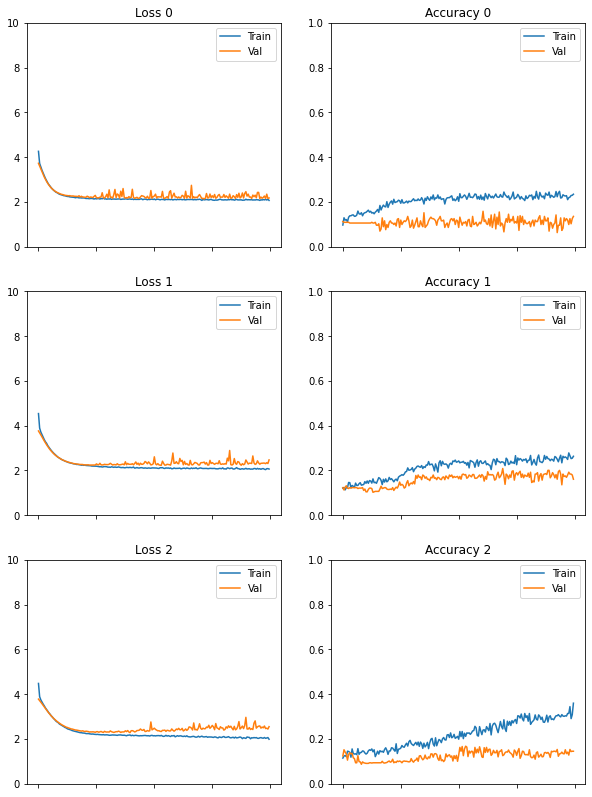

In [13]:
plot_metrics(hists)

#### Evaluate on test set

In [14]:
losses = []
accs = []
with open(os.path.join(model_folder, 'summary.txt'), 'a') as f:
    f.write('\n\ngroup\ttest loss\ttest accuracy\n')
    for i in range(no_splits):
        model = load_model(os.path.join(model_folder, f'{i}.hdf5'))
        loss, acc = model.evaluate(X_test, y_test)
        losses.append(loss)
        accs.append(acc)
        f.write(f'{i}\t{loss}\t{acc}\n')
    f.write(f'Avg\t{np.mean(losses)}\t{np.mean(accs)}\n')

866/866 [==============================] - 0s 553us/step
